In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sb
from statsmodels.tsa.seasonal import STL
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import urllib
#------------------
from dataset import TimeSeriesDataset
from models import MLR, MLP
from resnet_family import resnet20_cifar
from utils_cm import compute_cm

## Generate a synthetic time-series data

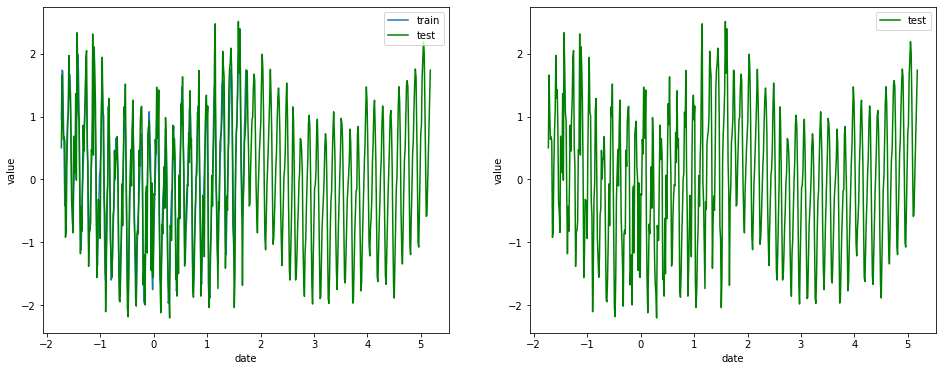

In [2]:
# data = np.loadtxt('data/co2_mm_mlo.txt')
# signal = pd.DataFrame(data[:, [2, 4]], columns=['date', 'average'])

import h5py

with h5py.File("data/co2/co2_train.h5", "r") as f:
    keys = list(f.keys())
    date = np.array(f[keys[0]]).reshape(-1, 1)
    value = np.array(f[keys[1]]).reshape(-1, 1)
    signal_train = pd.DataFrame(np.hstack([date, value]), columns=['date', 'value'])

with h5py.File("data/co2/co2_test.h5", "r") as f:
    keys = list(f.keys())
    date = np.array(f[keys[0]]).reshape(-1, 1)
    value = np.array(f[keys[1]]).reshape(-1, 1) * 0
    signal_test = pd.DataFrame(np.hstack([date, value]), columns=['date', 'value'])

signal_train_noisy = signal_train.copy()
signal_train_noisy.value = signal_train_noisy.value + .5 * np.random.randn(signal_train_noisy.shape[0])
# signal_test = pd.concat([signal_train_noisy, signal_test], axis=0).reset_index(drop=True)

signal_train_shifted = signal_train.copy()
signal_train_shifted.date = signal_train_shifted.date + (signal_train_shifted.date.max() - signal_train_shifted.date.min())
signal_test = pd.concat([signal_train_noisy, signal_train_shifted], axis=0).reset_index(drop=True)
    
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sb.lineplot(ax=ax[0], x='date', y='value', data=signal_train, label='train')
sb.lineplot(ax=ax[0], x='date', y='value', color='g', data=signal_test, label='test')
ax[0].legend()
sb.lineplot(ax=ax[1], x='date', y='value', color='g', data=signal_test, label='test')
ax[1].legend();

In [3]:
# stl = STL(train_labels, period=12, seasonal=7)
# stl_result = stl.fit()
# stl_result.plot()

In [11]:
train_labels = signal_train.value
train_data = np.hstack([signal_train.date.to_numpy().reshape(-1, 1)])
test_labels = signal_test.value
test_data = np.hstack([signal_test.date.to_numpy().reshape(-1, 1)])

In [12]:
train_data.shape, test_data.shape

((272, 1), (544, 1))

((216, 1), (216,))

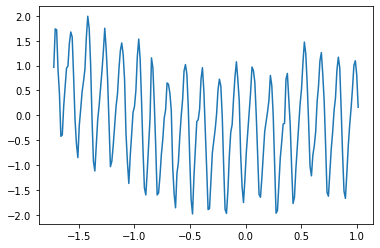

In [13]:
train_data = train_data[:12*18, :]
train_labels = np.array(train_labels[:12*18])
test_data = train_data
test_labels = train_labels

train_loader = DataLoader(TimeSeriesDataset(train_data, train_labels), batch_size=256, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(test_data, test_labels), batch_size=256, shuffle=False)
plt.plot(train_data, train_labels)
train_data.shape, train_labels.shape
# type(train_data), type(train_labels)

## [Training Model and Configuration](#Training-Model-and-Configuration)

In [14]:
hidden_layers = [1000, 1000, 1000, 1000]
dropout = 0
lr = 0.01
tau = 1
wd = 0.000005 #  0.01**2 * (1 - dropout) / (2. * len(train_loader) * tau)

model = MLR(input_size=train_data.shape[1], nclasses=1, hidden_layers=hidden_layers, dropout=dropout, batch_norm=True)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
model.net

Sequential(
  (0): Linear(in_features=1, out_features=1000, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=1000, out_features=1000, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=1000, out_features=1000, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=1000, out_features=1000, bias=True)
  (10): ReLU()
  (11): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=1000, out_features=1, bias=True)
)

In [ ]:
loss_vec = []
reset_loss_every = 100
n_epochs = 800
device = "cpu"
model.to(device)
model.train()

inputs = []
targets = []

for epoch in range(n_epochs+1):
    for it, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = batch
        output = model(data.float().to(device))
        loss = F.mse_loss(output, target.view(-1, 1).to(device))
        loss_vec.extend([loss.item()])
        loss.backward()
        optimizer.step()
        
        inputs.append(data.data.view(-1).numpy())
        targets.append(target.data.view(-1).numpy())
        
        if (it % reset_loss_every) == 0:
            print(f"epoch: {epoch}, it: {it}, average_loss: {np.mean(loss_vec)}")
            loss_vec = []
    if (epoch % n_epochs) == 0 and epoch > 0:
        lr *= 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

inputs = np.hstack(inputs)
targets = np.hstack(targets)
idx = np.argsort(inputs)
plt.plot(inputs[idx], targets[idx])

epoch: 0, it: 0, average_loss: 1.2065362930297852
epoch: 1, it: 0, average_loss: 73.83753967285156
epoch: 2, it: 0, average_loss: 53.54048538208008
epoch: 3, it: 0, average_loss: 4.6544413566589355
epoch: 4, it: 0, average_loss: 3.272120952606201
epoch: 5, it: 0, average_loss: 3.833425283432007
epoch: 6, it: 0, average_loss: 2.474860906600952
epoch: 7, it: 0, average_loss: 0.9513477683067322
epoch: 8, it: 0, average_loss: 1.261255145072937
epoch: 9, it: 0, average_loss: 1.8995680809020996
epoch: 10, it: 0, average_loss: 1.5229429006576538
epoch: 11, it: 0, average_loss: 0.925381064414978
epoch: 12, it: 0, average_loss: 0.9617805480957031
epoch: 13, it: 0, average_loss: 1.2626501321792603
epoch: 14, it: 0, average_loss: 1.2637513875961304
epoch: 15, it: 0, average_loss: 1.0271775722503662
epoch: 16, it: 0, average_loss: 0.889748752117157
epoch: 17, it: 0, average_loss: 0.9413493275642395
epoch: 18, it: 0, average_loss: 0.99565190076828
epoch: 19, it: 0, average_loss: 0.9700245261192322


epoch: 161, it: 0, average_loss: 0.6139220595359802
epoch: 162, it: 0, average_loss: 0.5484170913696289
epoch: 163, it: 0, average_loss: 0.6011441349983215
epoch: 164, it: 0, average_loss: 0.5267823338508606
epoch: 165, it: 0, average_loss: 0.5808561444282532
epoch: 166, it: 0, average_loss: 0.5114393830299377
epoch: 167, it: 0, average_loss: 0.5630154609680176
epoch: 168, it: 0, average_loss: 0.5038976073265076
epoch: 169, it: 0, average_loss: 0.5430270433425903
epoch: 170, it: 0, average_loss: 0.5010901689529419
epoch: 171, it: 0, average_loss: 0.5133487582206726
epoch: 172, it: 0, average_loss: 0.4985157549381256
epoch: 173, it: 0, average_loss: 0.49340876936912537
epoch: 174, it: 0, average_loss: 0.48612475395202637
epoch: 175, it: 0, average_loss: 0.4831426441669464
epoch: 176, it: 0, average_loss: 0.4726024270057678
epoch: 177, it: 0, average_loss: 0.47360891103744507
epoch: 178, it: 0, average_loss: 0.45959237217903137
epoch: 179, it: 0, average_loss: 0.48683229088783264
epoch: 

epoch: 320, it: 0, average_loss: 0.6496990323066711
epoch: 321, it: 0, average_loss: 0.9547332525253296
epoch: 322, it: 0, average_loss: 0.8948985934257507
epoch: 323, it: 0, average_loss: 0.4220893383026123
epoch: 324, it: 0, average_loss: 0.47253748774528503
epoch: 325, it: 0, average_loss: 0.6341677308082581
epoch: 326, it: 0, average_loss: 0.41912445425987244
epoch: 327, it: 0, average_loss: 0.4982805848121643
epoch: 328, it: 0, average_loss: 0.5009070038795471
epoch: 329, it: 0, average_loss: 0.3884248435497284
epoch: 330, it: 0, average_loss: 0.5046929717063904
epoch: 331, it: 0, average_loss: 0.37886959314346313
epoch: 332, it: 0, average_loss: 0.44468119740486145
epoch: 333, it: 0, average_loss: 0.403925359249115
epoch: 334, it: 0, average_loss: 0.4007450044155121
epoch: 335, it: 0, average_loss: 0.39330825209617615
epoch: 336, it: 0, average_loss: 0.3693901598453522
epoch: 337, it: 0, average_loss: 0.39025720953941345
epoch: 338, it: 0, average_loss: 0.34852510690689087
epoch:

In [ ]:
optimizer.param_groups[0]['lr']

In [ ]:
model.to(device)

# model.train()
model.eval()

ensemble_size = 10

gt = []
forecast = []
for it, batch in enumerate(test_loader):
    data, target = batch
    output = []
    for ensemble_it in range(ensemble_size):
        output.append(model(data.float().to(device)).data.numpy())
    output = np.hstack(output)
    forecast.append(output)
    gt.append(target.view(-1).data.numpy())
    
forecast = np.vstack(forecast)
predictive_mean = forecast.mean(1)
predictive_std = forecast.std(1)
print(predictive_mean.shape)
# print(predictive_std)
gt = np.hstack(gt)
mse_loss = ((gt - predictive_mean)**2).mean()
print(f"Test mse_loss = {mse_loss}")

fig, axes = plt.subplots(figsize=(16, 6))
axes.plot(train_data.squeeze(), train_labels.squeeze(), 'b', alpha=0.8);
axes.axvline(train_data.squeeze()[-1], color='g',linestyle='--');
axes.plot(test_data.squeeze(), predictive_mean, color='r', label="Forecast")
# axes.fill_between(test_data.squeeze(), predictive_mean-2*predictive_std, predictive_mean+2*predictive_std, label='prediction interval', color='g', alpha=0.9);
axes.legend();

In [556]:
list(model.parameters())[-2]

Parameter containing:
tensor([[-5.9019e-01, -5.8092e-01, -4.0087e-01, -4.4609e-01,  4.7241e-01,
         -4.8815e-01, -4.3901e-01,  1.6013e-02, -4.5436e-01,  1.2667e-01,
         -4.5451e-01,  3.2387e-01, -1.2507e+00, -6.3437e-01,  2.5907e-01,
         -4.2464e-01, -4.2634e-01, -4.3186e-01, -2.9645e-01, -6.0792e-01,
         -4.5153e-01, -4.5243e-01, -4.5108e-01, -1.8359e-01, -4.2699e-01,
          3.2755e-01,  1.5354e-03, -4.3060e-01, -4.3233e-01, -4.3544e-01,
          3.3877e-02,  1.2362e-01, -2.7467e-01, -4.6168e-01, -4.2824e-01,
         -6.0017e-01, -4.5290e-01,  2.8519e-01, -3.0842e-01, -4.3300e-01,
         -4.0278e-01,  4.6452e-01, -3.0954e-01, -4.2895e-01, -4.3945e-01,
         -4.2713e-01, -4.4563e-01, -4.6009e-01,  4.3835e-01, -3.1696e-01,
         -4.6064e-01, -6.2318e-01, -4.4574e-01, -3.2847e-01, -5.8063e-01,
         -2.3138e-01,  4.3043e-01, -1.9960e-01, -4.3183e-01, -6.6371e-01,
         -6.0672e-01,  2.5437e-01, -4.4875e-01, -2.7248e-01, -4.2909e-01,
          4.0048

Repeat the above training+evaluation experiment for two different values of DropourRate={0, 0.5} in the [Training-Model-and-Configuration](http://localhost:8888/notebooks/uncertainty_regression.ipynb#Training-Model-and-Configuration) cell (above) and see how that single change introduces the prediction interval.